In [1]:
import sys
sys.path.append("../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from modelsnew import *
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.MNIST('./data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('./data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
activation = hard_sigmoid
# activation = F.relu
criterion = torch.nn.MSELoss(reduction='none').to(device)

In [5]:
architecture = [784, 500, 10]

x,y = next(iter(train_loader))
x = x.view(x.size(0),-1).to(device).T
y_one_hot = F.one_hot(y, 10).to(device).T

beta = 1
lambda_h = 0.9999
lambda_y = 0.9999
epsilon = 0.15#0.5
psiv=0.1 #0.9
one_over_epsilon = 1 / epsilon
lr_start = {'ff' : 0.275, 'fb': 0.05, 'lat': 1e-3}
neural_lr_start = 0.01
neural_lr_stop = 1e-3
neural_lr_rule = "constant"
neural_lr_decay_multiplier = 0.01
model = TwoLayerCorInfoMax(architecture = architecture, lambda_h = lambda_h, lambda_y = lambda_y, psiv=psiv,
                           epsilon = epsilon, activation = activation)
#model.B[1]['weight']=10*model.B[1]['weight']
#model.B[0]['weight']=3*model.B[0]['weight']

In [6]:
trn_acc_list = []
tst_acc_list = []
neural_dynamic_iterations_free = 20
neural_dynamic_iterations_nudged = 10

n_epochs = 50


for epoch_ in range(n_epochs):
    lr = {'ff' : lr_start['ff'] * (0.99)**epoch_, 'fb' : lr_start['fb'] * (0.99)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T

        if True:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
        h, y_hat = model.batch_step_EP(  x, y_one_hot, lr, neural_lr_start, neural_lr_stop,
                                         neural_lr_rule, neural_lr_decay_multiplier,
                                         neural_dynamic_iterations_free, 
                                         neural_dynamic_iterations_nudged, beta)

    trn_acc = evaluateCorInfoMaxV2(model, train_loader, neural_lr_start, neural_lr_stop, neural_lr_rule, neural_lr_decay_multiplier,
                                   neural_dynamic_iterations_free, device = 'cuda', printing = False)
    tst_acc = evaluateCorInfoMaxV2(model, test_loader, neural_lr_start, neural_lr_stop, neural_lr_rule, neural_lr_decay_multiplier,
                                   neural_dynamic_iterations_free, device = 'cuda', printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
#     lr = {'ff' : 0.05 * (0.9)**epoch_, 'fb': 0.05 * (0.9) ** epoch_, 'lat': 1e-3}
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))
    

3000it [00:32, 93.32it/s]
9it [00:00, 84.83it/s]

Epoch : 1, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:32, 92.68it/s]
9it [00:00, 86.16it/s]

Epoch : 2, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.0979


3000it [00:31, 95.06it/s]
9it [00:00, 84.76it/s]

Epoch : 3, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 96.19it/s]
9it [00:00, 86.75it/s]

Epoch : 4, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 95.02it/s]
9it [00:00, 86.09it/s]

Epoch : 5, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:31, 95.07it/s]
9it [00:00, 86.15it/s]

Epoch : 6, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 96.12it/s]
9it [00:00, 85.63it/s]

Epoch : 7, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 95.40it/s]
9it [00:00, 86.91it/s]

Epoch : 8, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 95.03it/s]
9it [00:00, 87.16it/s]

Epoch : 9, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:31, 95.57it/s]
9it [00:00, 86.98it/s]

Epoch : 10, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:31, 96.07it/s]
9it [00:00, 86.85it/s]

Epoch : 11, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:31, 94.67it/s]
9it [00:00, 86.34it/s]

Epoch : 12, Train Accuracy : 0.1124, Test Accuracy : 0.1135


3000it [00:31, 95.16it/s]
9it [00:00, 87.10it/s]

Epoch : 13, Train Accuracy : 0.0987, Test Accuracy : 0.098


3000it [00:31, 96.15it/s]
9it [00:00, 82.10it/s]

Epoch : 14, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:31, 95.23it/s]
9it [00:00, 87.17it/s]

Epoch : 15, Train Accuracy : 0.11238333333333334, Test Accuracy : 0.1135


3000it [00:31, 94.93it/s]
9it [00:00, 86.88it/s]

Epoch : 16, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:31, 94.71it/s]
5it [00:00, 46.70it/s]

Epoch : 17, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:31, 95.37it/s]
10it [00:00, 94.60it/s]

Epoch : 18, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:31, 94.55it/s]
10it [00:00, 92.95it/s]

Epoch : 19, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:31, 94.60it/s]
10it [00:00, 91.29it/s]

Epoch : 20, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:31, 95.35it/s]
10it [00:00, 95.10it/s]

Epoch : 21, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 95.73it/s]
10it [00:00, 95.00it/s]

Epoch : 22, Train Accuracy : 0.09868333333333333, Test Accuracy : 0.098


3000it [00:31, 95.96it/s]
10it [00:00, 95.18it/s]

Epoch : 23, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:31, 95.38it/s]
10it [00:00, 94.97it/s]

Epoch : 24, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:31, 94.96it/s]
10it [00:00, 94.66it/s]

Epoch : 25, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:31, 95.97it/s]
10it [00:00, 95.44it/s]

Epoch : 26, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 95.15it/s]
10it [00:00, 94.44it/s]

Epoch : 27, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:32, 93.62it/s]
10it [00:00, 93.07it/s]

Epoch : 28, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:31, 95.21it/s]
10it [00:00, 94.69it/s]

Epoch : 29, Train Accuracy : 0.09866666666666667, Test Accuracy : 0.098


3000it [00:31, 95.63it/s]
10it [00:00, 94.02it/s]

Epoch : 30, Train Accuracy : 0.09863333333333334, Test Accuracy : 0.098


3000it [00:31, 95.12it/s]
10it [00:00, 94.65it/s]

Epoch : 31, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:32, 92.97it/s]
10it [00:00, 94.18it/s]

Epoch : 32, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:31, 95.83it/s]
10it [00:00, 94.64it/s]

Epoch : 33, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 94.25it/s]
10it [00:00, 95.16it/s]

Epoch : 34, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:31, 94.88it/s]
10it [00:00, 95.33it/s]

Epoch : 35, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 95.95it/s]
10it [00:00, 92.39it/s]

Epoch : 36, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 96.01it/s]
10it [00:00, 96.10it/s]

Epoch : 37, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 95.65it/s]
10it [00:00, 95.26it/s]

Epoch : 38, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:31, 95.21it/s]
10it [00:00, 94.15it/s]

Epoch : 39, Train Accuracy : 0.11236666666666667, Test Accuracy : 0.1135


3000it [00:31, 96.26it/s]
10it [00:00, 91.95it/s]

Epoch : 40, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 94.96it/s]
10it [00:00, 92.99it/s]

Epoch : 41, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 95.09it/s]
10it [00:00, 90.83it/s]

Epoch : 42, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 95.77it/s]
10it [00:00, 94.85it/s]

Epoch : 43, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 95.59it/s]
10it [00:00, 92.83it/s]

Epoch : 44, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 95.16it/s]
10it [00:00, 94.74it/s]

Epoch : 45, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 95.47it/s]
10it [00:00, 94.10it/s]

Epoch : 46, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 95.92it/s]
10it [00:00, 95.39it/s]

Epoch : 47, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 95.17it/s]
10it [00:00, 94.88it/s]

Epoch : 48, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 95.43it/s]
10it [00:00, 94.11it/s]

Epoch : 49, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


3000it [00:31, 95.33it/s]


Epoch : 50, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


In [7]:
torch.trace(model.B[0]['weight'])/architecture[1]

tensor(nan, device='cuda:0')

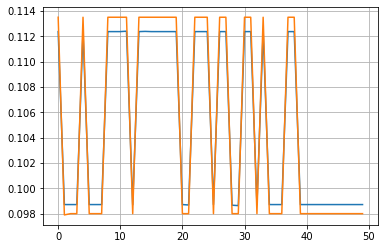

In [8]:
plt.plot(trn_acc_list)
plt.plot(tst_acc_list)
plt.grid()
plt.show()

In [9]:
model.Wff

array([{'weight': tensor([[nan, nan, nan,  ..., nan, nan, nan],
               [nan, nan, nan,  ..., nan, nan, nan],
               [nan, nan, nan,  ..., nan, nan, nan],
               ...,
               [nan, nan, nan,  ..., nan, nan, nan],
               [nan, nan, nan,  ..., nan, nan, nan],
               [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0'), 'bias': tensor([[nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               [nan],
               